# **Policy Gradient**

# Task description

We follow the structure of the tutorial, set up the environment, implement the policy gradient method as a baseline model. And we try different ways to improve the performance of the policy.

# Environment
install the necessary system kit and pypi kit.

In [ ]:
!apt install python3-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip3 install pyvirtualdisplay numpy torch torchvision torchaudio gymnasium tqdm matplotlib jupyter
!pip install swig
!pip install gym[box2d]
!pip install box2d-py ipykernel ipywidgets widgetsnbextension

Next, set up the virtual display and introduce all necessary packages.

In [10]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Utilize GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Game Environment Test

We use “LunarLander-v2” in OpenAI gym as the environment of the simulator.

We use the `step()` function to make the agent act, and then the function will return the observation / state

In [11]:
%%capture
import gymnasium as gym
env = gym.make('LunarLander-v2', render_mode='rgb_array')

In [14]:
initial_state = env.reset()
print(initial_state)

(array([ 0.00744886,  1.4023924 ,  0.75446093, -0.37903437, -0.00862445,
       -0.17089637,  0.        ,  0.        ], dtype=float32), {})


### Random Agent

A random agent as a benchmark

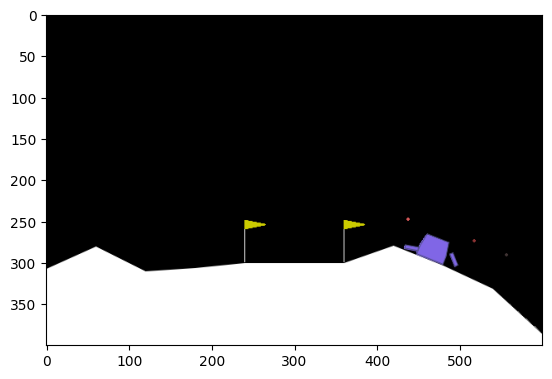

In [20]:
env.reset()

img = plt.imshow(env.render())

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Learn optimal policy to play the game by Policy Gradient algorithm  
Let $\pi_{\theta}$ denote a policy with parameters $\theta$, and $J(\pi_{\theta})$ denote the expected finite-horizon undiscounted return of the policy. The gradient of $J(\pi_{\theta})$ is

$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}{
    \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t|s_t) A^{\pi_{\theta}}(s_t,a_t)
    }$, where $\tau$ is a trajectory and $A^{\pi_{\theta}}$ is the advantage function for the current policy.

The policy gradient algorithm works by updating policy parameters via stochastic gradient ascent on policy performance:

$\theta_{k+1} = \theta_k + \alpha \nabla_{\theta} J(\pi_{\theta_k})$.

Policy gradient implementations typically compute advantage function estimates based on the infinite-horizon discounted return, despite otherwise using the finite-horizon undiscounted policy gradient formula.

## Implementation
Now let's build a simple policy network.
The input of our default model is 8-dim observation, and the output is one of the four discrete actions:

In [21]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 4)

    def forward(self, state):
        hid = torch.relu(self.fc1(state))
        hid = torch.relu(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

Next, build a simple agent and take action with the policy network above.

This agent can do the following things:

-` learn() `: update the policy network from the recorded log probabilities and rewards.

-` sample() `: after obtaining the observation from the environment, use the policy network to get the action that should be taken.

In addition to returning the sampled action, this function will also return the log probabilities of this sampling.

In [22]:
class PolicyGradientAgent():
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

Finally, establish a network and agent, and you can start training.

In [23]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Train the Agent

Now let's start training the agent.

By making the agent interact with the environment, we remember the log probabilities and reward corresponding to each group, and play back these "memories" to train the policy network after successful login or unfortunate crash.

In [24]:
agent.network.train()  # Before training, please make sure that the network is in training mode
EPISODE_PER_BATCH = 10  # Update the agent every 5 episodes collected
NUM_BATCH = 1600        # 400 updates in total

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    # Collect training data
    for episode in range(EPISODE_PER_BATCH):
        state, _ = env.reset()
        total_reward, total_step = 0, 0
        while True:
            action, log_prob = agent.sample(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1
            done = terminated or truncated
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards.append(np.full(total_step, total_reward))  # Set the same episode, and the reward of each action is total reward
                break
    # Record the training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update the network
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # Normalize reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

  0%|          | 0/400 [00:00<?, ?it/s]

### Training results

During the training, we kept recording ` AVG_ total_ Reward `, this value represents: before updating the policy network each time, we let the agent play several rounds (episodes), and what is the average total rewards of these rounds.

Theoretically, if the agent has been making progress, the obtained ` AVG_ total_ Reward 'will also continue to rise up to 250.

If it is drawn, the results are as follows:

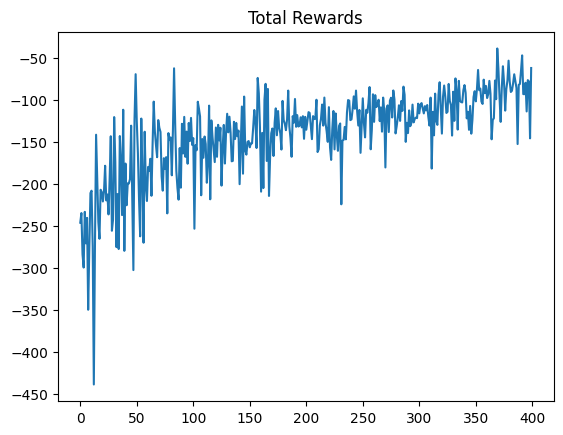

In [25]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

Also, ` avg_total_reward` represents the average final rewards of multiple rounds, and the final reward is the last reward obtained by the agent in a single round.

If you still remember the way the environment gives the lunar landing boat a reward, they will know that no matter whether the * * boat crashes, flies out of the picture, or stands still on the ground at the end of the * * round, it will receive additional rewards or punishment.

Therefore, final reward can be used to observe whether the "landing" of the agent is smooth.

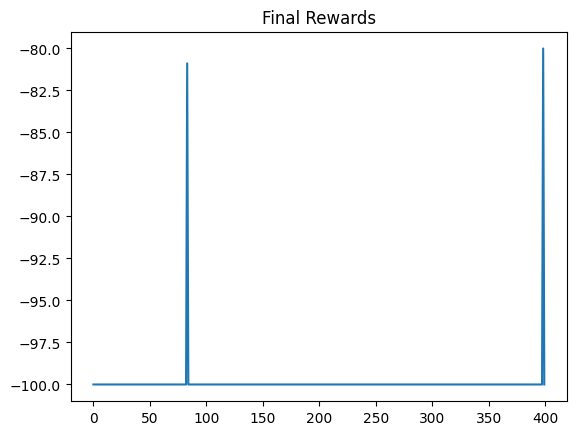

In [26]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing

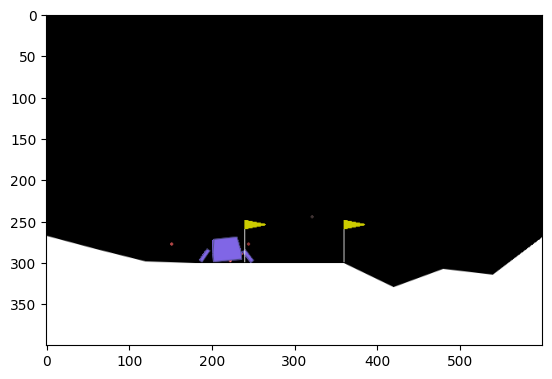

In [27]:
agent.network.eval()  # Switch the network to the evaluation mode before testing

state, _ = env.reset()

img = plt.imshow(env.render())

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [28]:
print(total_reward)

-56.1922988006977
